# Intel Scene Classification Project

## Introduction

In this notebook, we will be using the dataset that is been provided by Intel containing 6 different categories of the natural scenes taken around the world.

The data that is been provided is in image format, a total of ~25K images in 150 X 150 size.

**Potential Application:** This can be used in multiple devices to categorize different images that a user has taken or downloaded a natural scene photo.
For e.g. A tourist that clicks multiple photos during his/her adventure, can have the images get automatically segregated into specific folders.

**Problem Statement:** To build a model that can categorize unlabelled "Intel Images Dataset" of natural scene into 6 different classes.

---

## 1. Become one with dataset.

In [ ]:
# Importing all the necessary packages needed
import os
import pathlib
import tarfile
import random
import datetime
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import Model, mixed_precision
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPool2D, Flatten, Dense, Activation
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomHeight, RandomWidth
from tensorflow.keras.layers import InputLayer, Input, GlobalAveragePooling2D
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

We will be loading the dataset from [kaggle.com](https://www.kaggle.com/datasets/puneet6060/intel-image-classification) and extracting it.

In [ ]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Downloading the dataset
# Copying my Kaggle API in root folder
!cp "/content/drive/MyDrive/Colab Notebooks/kaggle.json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Downloading the dataset from kaggle and unzipping the file
!kaggle datasets download -d puneet6060/intel-image-classification -p ./data/ --unzip 

 95% 329M/346M [00:06<00:00, 40.0MB/s]
100% 346M/346M [00:06<00:00, 57.4MB/s]


There are three folders in the dataset: train, test and predict.

Lets check out each folder.

In [ ]:
# Directories of train, test and predict dataset.
train_dir = "data/seg_train/seg_train/" 
test_dir = "data/seg_test/seg_test/"
pred_dir = "data/seg_pred/seg_pred/"

In [ ]:
# Reading the data folder.
total_images = []
all_dirnames = []
for i in (train_dir, test_dir, pred_dir):
    for dirpath, dirnames, filenames in os.walk(i):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")
        total_images.append(len(filenames))
        all_dirnames.append(dirnames)
print(f"Total images in Dataset are: {sum(total_images)}, which are split in Training set: {sum(total_images[1:7])}, Testing set: {sum(total_images[8:-1])}, and Prediction set: {total_images[-1]}.")

There are 6 directories and 0 images in data/seg_train/seg_train/
There are 0 directories and 2271 images in data/seg_train/seg_train/forest
There are 0 directories and 2191 images in data/seg_train/seg_train/buildings
There are 0 directories and 2274 images in data/seg_train/seg_train/sea
There are 0 directories and 2382 images in data/seg_train/seg_train/street
There are 0 directories and 2404 images in data/seg_train/seg_train/glacier
There are 0 directories and 2512 images in data/seg_train/seg_train/mountain
There are 6 directories and 0 images in data/seg_test/seg_test/
There are 0 directories and 474 images in data/seg_test/seg_test/forest
There are 0 directories and 437 images in data/seg_test/seg_test/buildings
There are 0 directories and 510 images in data/seg_test/seg_test/sea
There are 0 directories and 501 images in data/seg_test/seg_test/street
There are 0 directories and 553 images in data/seg_test/seg_test/glacier
There are 0 directories and 525 images in data/seg_test/

So, the data is been split at ~80:20 ratio.

In [ ]:
# Getting the class names
data_dir = pathlib.Path(train_dir)
label_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(label_names)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


Good, now that we have the data and labels for it.

How about we visualize the data?

Text(0.5, 0.98, 'Dataset Proportion for Training and Testing')

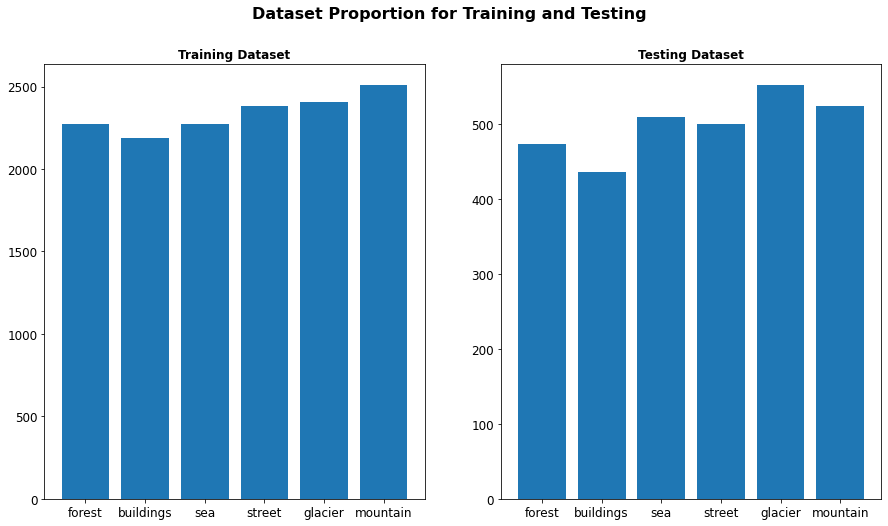

In [ ]:
# Train and test data proportion.
plt.figure(figsize=(15,8))

# Training dataset
plt.subplot(1,2,1)
plt.bar(all_dirnames[0], total_images[1:7])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Training Dataset', size=12, weight='bold')

# Testing dataset
plt.subplot(1,2,2)
plt.bar(all_dirnames[0], total_images[8:-1])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Testing Dataset', size=12, weight='bold')

plt.suptitle('Dataset Proportion for Training and Testing', size=16, weight='bold')

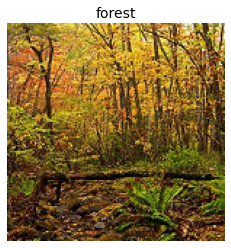

In [ ]:
# View random images from training set.
# Creating a function to view random images 
def view_random_images(target_dir, target_class):
    """
    View any random images from any directory

    Args: target_dir - Train or Test Directory.
          target_class - Class Labels.
    """
    target_folder = target_dir + target_class
    random_img = random.sample(os.listdir(target_folder),1)
    img = mpimg.imread(target_folder + "/" + random_img[0])
    plt.imshow(img)
    plt.title(target_class, size=14)
    plt.axis(False)

view_random_images(train_dir, random.choice(label_names))

Perfect, now lets view all the classes.

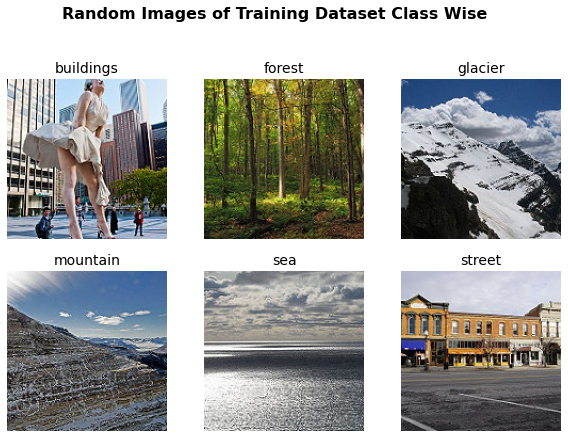

In [ ]:
# Visualizing all the classes.
plt.figure(figsize=(10,10))
for i in range(6):
    plt.subplot(3,3,i + 1)
    view_random_images(train_dir, label_names[i])
    plt.suptitle('Random Images of Training Dataset Class Wise', size=16, weight='bold')

---

## 2. Preprocess the data

There are two ways that I know to preprocess our data in tensorflow.
1. Using ```ImageDataGenerator``` and ```flow_from_directory```
2. Using ```image_dataset_from_directory```.

The most popular method is the first one, but tensorflow(2.10) documentation has kind of deprecated the method not only that the whole category of preprocessing is not recommended by tensorflow.

So, to demonstrate both, we will use the ```ImageDataGenerator``` function for our baseline model then we will use the ```image_dataset_from_directory``` for rest of the models.

In [ ]:
# Create data generator instance
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

#Load dataset to the ImageDataGenerator function
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(150,150),
                                               batch_size=32,
                                               class_mode='categorical')
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(150,150),
                                             batch_size=32,
                                             class_mode='categorical')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


The number of images that the dataloader has found and processed is correct.

Lets check what the function above has done to our dataset.

In [ ]:
train_data, test_data

(<keras.preprocessing.image.DirectoryIterator at 0x7f0764e0a4d0>,
 <keras.preprocessing.image.DirectoryIterator at 0x7f0764e0aed0>)

There are two tensors in each of our train and test dataset.

Lets check it out!

In [ ]:
train_data.next()

(array([[[[0.70980394, 0.70980394, 0.70980394],
          [0.7058824 , 0.7058824 , 0.7058824 ],
          [0.7058824 , 0.7058824 , 0.7058824 ],
          ...,
          [0.76470596, 0.76470596, 0.76470596],
          [0.7607844 , 0.7607844 , 0.7607844 ],
          [0.77647066, 0.77647066, 0.77647066]],
 
         [[0.70980394, 0.70980394, 0.70980394],
          [0.70980394, 0.70980394, 0.70980394],
          [0.7058824 , 0.7058824 , 0.7058824 ],
          ...,
          [0.77647066, 0.77647066, 0.77647066],
          [0.76470596, 0.76470596, 0.76470596],
          [0.7411765 , 0.7411765 , 0.7411765 ]],
 
         [[0.68235296, 0.68235296, 0.68235296],
          [0.6862745 , 0.6862745 , 0.6862745 ],
          [0.69411767, 0.69411767, 0.69411767],
          ...,
          [0.7686275 , 0.7686275 , 0.7686275 ],
          [0.72156864, 0.72156864, 0.72156864],
          [0.67058825, 0.67058825, 0.67058825]],
 
         ...,
 
         [[0.12941177, 0.12941177, 0.12941177],
          [0.13333

What we see right now is the first batch of our training datset, where the first tensor has shape of (Batch_Size, Height, Width, Color Channels) and the second tensor has the shape of (Batch_Size, Labels), with 32 images data and labels of the same in one hot encoded format.

In [ ]:
# Total no. batches created for our datasets.
len(train_data), len(test_data)

(439, 94)

Lets now visualize the training dataset after preprocessing.

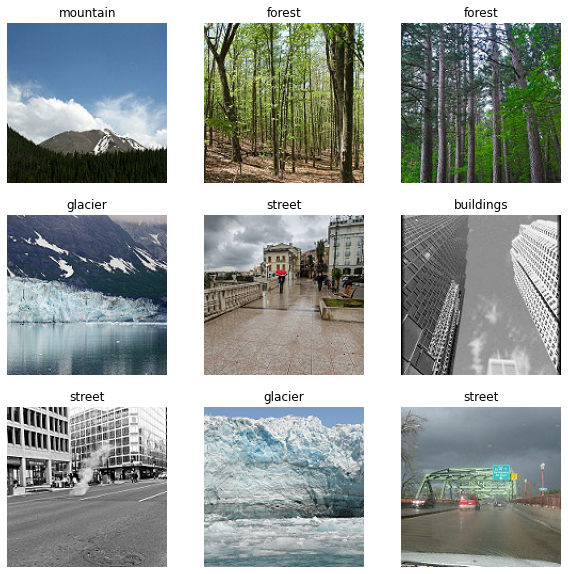

In [ ]:
plt.figure(figsize=(10,10))
images, labels = train_data.next()
for i in range(9):
    ax = plt.subplot(3, 3, i + 1),
    plt.imshow(images[i])
    plt.title(label_names[labels[i].argmax()])
    plt.axis(False)

---

## 3. Building a Baseline Model - Model_0

All the data of images and labels are in tensor format which can go through the model and layers perfectly.

We will be creating a small and simple model to understand the data performance.

In [ ]:
# Creating the Model_0
model_0 = Sequential([
    Conv2D(10, 3, activation='relu', input_shape=(150, 150, 3)),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(6, activation='softmax')
])

# Compiling the model_0
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

---

## 4. Fitting the Model

Now, that we have created the model and compiled it to suit our dataset. 

It's time to fit the model

In [ ]:
# Before we fit the model, we will create a function for our tensorboard callback.
def tensorboard_callbacks(dir_name, exp_name):
    """
    Creates a TensorBoard callback instance to store log files.
    
    Stores log files with the filepath:
      "dir_name/experiment_name/current_datetime/"
    
    Args:
      dir_name: target directory to store TensorBoard log files
      experiment_name: name of experiment directory (e.g. efficientnet_model_1)
    """
    log_dir = dir_name + '/' + exp_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H:%M:%S')
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving the log of Tensorboard Callabck in directory: {log_dir}")
    return tb_callback

In [ ]:
# Fitting the model
history_0 = model_0.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[tensorboard_callbacks('tensorboard_callbacks', 'baseline_model_0')])

Saving the log of Tensorboard Callabck in directory: tensorboard_callbacks/baseline_model_0/20221026-13:19:00
Epoch 1/5
439/439 [==============================] - 32s 54ms/step - loss: 1.0411 - accuracy: 0.6014 - val_loss: 0.8073 - val_accuracy: 0.7020
Epoch 2/5
439/439 [==============================] - 22s 49ms/step - loss: 0.7609 - accuracy: 0.7221 - val_loss: 0.6964 - val_accuracy: 0.7450
Epoch 3/5
439/439 [==============================] - 21s 48ms/step - loss: 0.6496 - accuracy: 0.7676 - val_loss: 0.7028 - val_accuracy: 0.7463
Epoch 4/5
439/439 [==============================] - 21s 48ms/step - loss: 0.5942 - accuracy: 0.7865 - val_loss: 0.6380 - val_accuracy: 0.7677
Epoch 5/5
439/439 [==============================] - 21s 48ms/step - loss: 0.5489 - accuracy: 0.8036 - val_loss: 0.6374 - val_accuracy: 0.7627


In [ ]:
model_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 10)      280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 10)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 10)        910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 10)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 10)        910       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 10)       0

This is great. The baseline model is working awesome.

---

## 5. Evaluate our Model

Lets evaluate and visualize our models loss and accuracy curves.

In [ ]:
# Evaluating our model on test data
model_0.evaluate(test_data)

94/94 [==============================] - 4s 38ms/step - loss: 0.6374 - accuracy: 0.7627


[0.6374278664588928, 0.762666642665863]

In [ ]:
# Creating a function to for plotting our loss and accuracy curves
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    
    Args:
      history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
    """
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    accuracy=history.history['accuracy']
    val_accuracy=history.history['val_accuracy']
    epochs=range(len(loss))
  
    plt.figure(figsize=(15, 5))
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title("Loss", weight="bold")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title("Accuracy", weight="bold")
    plt.xlabel("Epochs")
    plt.legend()

    plt.suptitle("Loss and Accuracy Curves of the Model", size=14, weight='bold')

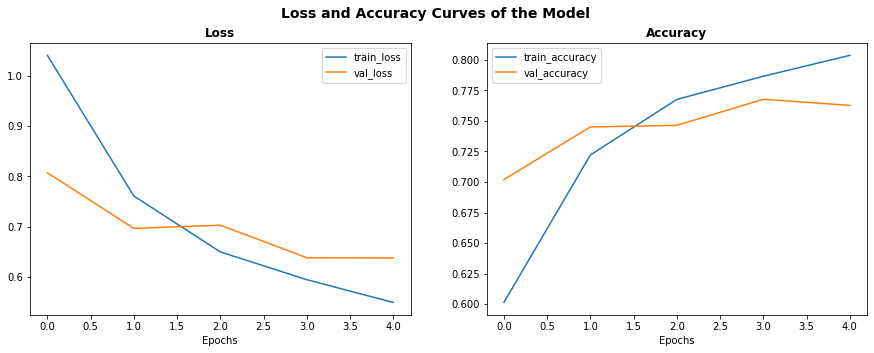

In [ ]:
# Plotting Loss and Accuracy curves
plot_loss_curves(history_0)

loss curves are indicating towards overfitting while accurcy curves are showing good results.

---

## 6. Adjusting the Parameters.

Now, we will see whether data augmentation has any major changes with the result on the same model.

In [ ]:
# Create augmented data generator instance
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True)
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                  target_size=(150,150),
                                                                  batch_size=32,
                                                                  class_mode='categorical')

Found 14034 images belonging to 6 classes.


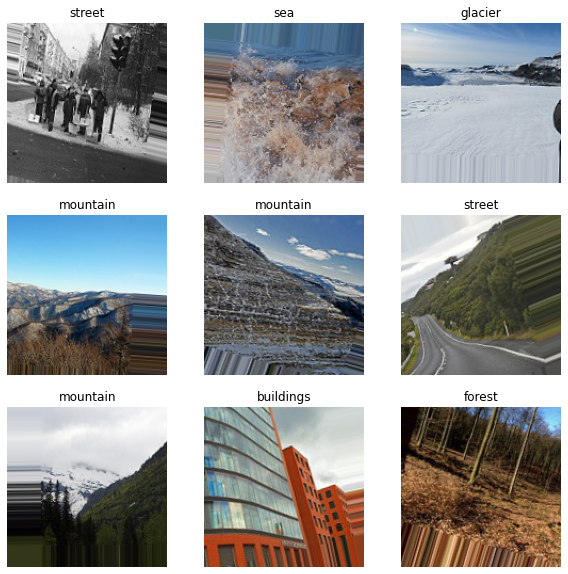

In [ ]:
# Visualizing the augmented dataset
plt.figure(figsize=(10,10))
images, labels = train_data_augmented.next()
for i in range(9):
    ax = plt.subplot(3, 3, i + 1),
    plt.imshow(images[i])
    plt.title(label_names[labels[i].argmax()])
    plt.axis(False)

In [ ]:
# Cloning or baseline model and fiting it to the augmented data.
model_1 = tf.keras.models.clone_model(model_0)

# Compile the cloned model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data_augmented, # use augmented data
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[tensorboard_callbacks('tensorboard_callbacks', 'baseline_dataaug_model_1')])

Saving the log of Tensorboard Callabck in directory: tensorboard_callbacks/baseline_dataaug_model_1/20221026-13:21:25
Epoch 1/5
439/439 [==============================] - 80s 182ms/step - loss: 1.2220 - accuracy: 0.5183 - val_loss: 0.9746 - val_accuracy: 0.6533
Epoch 2/5
439/439 [==============================] - 81s 185ms/step - loss: 0.9962 - accuracy: 0.6144 - val_loss: 1.1628 - val_accuracy: 0.5303
Epoch 3/5
439/439 [==============================] - 80s 182ms/step - loss: 0.9268 - accuracy: 0.6514 - val_loss: 0.8220 - val_accuracy: 0.7033
Epoch 4/5
439/439 [==============================] - 79s 181ms/step - loss: 0.8677 - accuracy: 0.6783 - val_loss: 0.7463 - val_accuracy: 0.7147
Epoch 5/5
439/439 [==============================] - 81s 183ms/step - loss: 0.8405 - accuracy: 0.6908 - val_loss: 0.7097 - val_accuracy: 0.7427


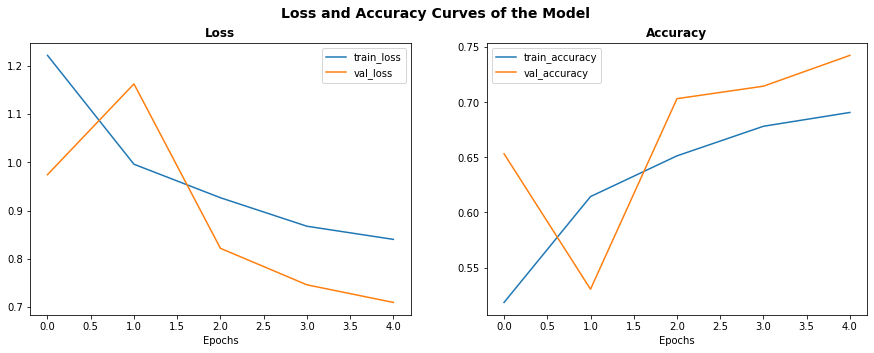

In [ ]:
# Plotting Loss and Accuracy curves
plot_loss_curves(history_1)

This clearly shows us that our baseline model will have some limitations when the images are not their perfect versions.

---

## 7. Feature Extraction - Transfer Learning Model

Lets imporve our result using transfer learning. 

We will be using the tf.keras.application to load the pretrained architectures with their pretrained weights on ImageNet or similar huge computer vision datasets.

Now, we will be using the recommended way to create data inputs, together with tf.data.prefetch method which will help in loading the data much faster, and will be using the functional model method in this section.

In [ ]:
# Create data inputs 
train_data = image_dataset_from_directory(train_dir,
                                          image_size=(150, 150),
                                          label_mode='categorical',
                                          batch_size=32).prefetch(tf.data.AUTOTUNE)
test_data = image_dataset_from_directory(test_dir,
                                         image_size=(150, 150),
                                         label_mode='categorical',
                                         batch_size=32,
                                         shuffle=False).prefetch(tf.data.AUTOTUNE)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [ ]:
# Check the data inputs
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>)

In [ ]:
# Checking our first batch of images and labels.
for images, labels in train_data.take(1):
    print(images, labels)

tf.Tensor(
[[[[178. 177. 195.]
   [189. 188. 206.]
   [194. 193. 209.]
   ...
   [254. 254. 246.]
   [255. 252. 245.]
   [247. 244. 237.]]

  [[225. 224. 240.]
   [219. 221. 236.]
   [232. 231. 245.]
   ...
   [255. 255. 250.]
   [255. 255. 250.]
   [247. 242. 238.]]

  [[231. 233. 245.]
   [213. 217. 228.]
   [217. 219. 231.]
   ...
   [242. 238. 237.]
   [223. 214. 215.]
   [208. 199. 200.]]

  ...

  [[ 81.  72.  73.]
   [ 49.  39.  38.]
   [120. 106. 106.]
   ...
   [112.  85.  74.]
   [ 94.  76.  62.]
   [ 86.  73.  56.]]

  [[ 51.  41.  40.]
   [ 65.  53.  53.]
   [130. 116. 116.]
   ...
   [ 96.  68.  57.]
   [ 54.  32.  19.]
   [ 66.  48.  34.]]

  [[100.  90.  89.]
   [ 97.  85.  85.]
   [ 75.  61.  60.]
   ...
   [202. 172. 164.]
   [243. 219. 207.]
   [104.  85.  71.]]]


 [[[ 45. 126. 205.]
   [ 55. 133. 216.]
   [ 45. 118. 210.]
   ...
   [ 35.  52. 121.]
   [ 63.  85. 161.]
   [ 23.  48. 130.]]

  [[ 41. 122. 204.]
   [ 46. 124. 209.]
   [ 50. 125. 216.]
   ...
   [ 22.  

In [ ]:
# Total no. batches created for our datasets.
len(train_data), len(test_data)

(439, 94)

Everything is same, just the method is changed.

Now, lets setup a mixed precision training, this will help in utilizing the gpu memory much more efficiently and improve our training performance.

Note - for better performance keras tells us to use mixed_float16, but we will be using float32(default) due to model EfficientNetB0 which doesnot accept mixed precision for some reason. 

In [ ]:
# Turning on the mixed precision training
mixed_precision.set_global_policy(policy="float32")
mixed_precision.global_policy()

<Policy "float32">

Great, with this our model will automatically take the advantage of float16 policy where ever it needs to speed up the training process.

Now, finally we will setup a model checkpoint callback. This will save the models progress at certain intervals which will help in reusing the model at later stages.

In [ ]:
# Creating model checkpoint callback
checkpoint_path = "model_checkpoint/checkpoint.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=1)

### 1. EfficientNetB0

First we will use a EfficientNetB0 architecture which has shown good results and is the simplest in the EfficientNet Module, EfficientNet ranges from B0 to B7, where the complexity and the training paramters increase with every range.

![](https://1.bp.blogspot.com/-DjZT_TLYZok/XO3BYqpxCJI/AAAAAAAAEKM/BvV53klXaTUuQHCkOXZZGywRMdU9v9T_wCLcBGAs/s1600/image2.png)

*The architecture for our network EfficientNet-B0 is simple and clean, making it easier to scale and generalize.*

In [ ]:
# In this model, we will be using functional model method.
# Loading the core model
base_efficientnetb0_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_efficientnetb0_model.trainable = False

# Creating Functional model
inputs = Input(shape=(150,150,3), name='input_layer')
x = base_efficientnetb0_model(inputs)
x = GlobalAveragePooling2D(name='global_average_pool2d')(x)
x = Dense(len(label_names), name='dense_output_layer')(x)
outputs = Activation('softmax', dtype=tf.float32, name='softmax_float32')(x) # Output layer needs to be in float32 precision.
model_2 = Model(inputs, outputs)

# Compiling the model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# Checking our 
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 150, 150, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pool2d (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 dense_output_layer (Dense)  (None, 6)                 7686      
                                                                 
 softmax_float32 (Activation  (None, 6)                0         
 )                                                               
                                                                 
Total params: 4,057,257
Trainable params: 7,686
Non-trainab

In [ ]:
# Lets check the dtype policy of the core model and the training model
for layer in model_2.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "float32">
global_average_pool2d True float32 <Policy "float32">
dense_output_layer True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">


In [ ]:
for layer in model_2.layers[1].layers[:10]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_21 False float32 <Policy "float32">
rescaling_19 False float32 <Policy "float32">
normalization_19 False float32 <Policy "float32">
tf.math.truediv_19 False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "float32">
stem_conv False float32 <Policy "float32">
stem_bn False float32 <Policy "float32">
stem_activation False float32 <Policy "float32">
block1a_dwconv False float32 <Policy "float32">
block1a_bn False float32 <Policy "float32">


In [ ]:
# Fit the Feature Extraction model
history_efficientb0_2 = model_2.fit(train_data,
                                    epochs=5,
                                    steps_per_epoch=len(train_data),
                                    validation_data=test_data,
                                    validation_steps=int(0.15 * len(test_data)),
                                    callbacks=[tensorboard_callbacks('tensorboard_callbacks', 'efficientnetb0_model_2')])

Saving the log of Tensorboard Callabck in directory: tensorboard_callbacks/efficientnetb0_model_2/20221026-14:38:53
Epoch 1/5
439/439 [==============================] - 24s 39ms/step - loss: 0.3429 - accuracy: 0.8863 - val_loss: 0.2363 - val_accuracy: 0.9107
Epoch 2/5
439/439 [==============================] - 16s 35ms/step - loss: 0.2198 - accuracy: 0.9227 - val_loss: 0.2255 - val_accuracy: 0.9129
Epoch 3/5
439/439 [==============================] - 16s 35ms/step - loss: 0.1974 - accuracy: 0.9298 - val_loss: 0.2071 - val_accuracy: 0.9196
Epoch 4/5
439/439 [==============================] - 16s 35ms/step - loss: 0.1802 - accuracy: 0.9357 - val_loss: 0.2351 - val_accuracy: 0.9085
Epoch 5/5
439/439 [==============================] - 16s 35ms/step - loss: 0.1727 - accuracy: 0.9376 - val_loss: 0.1905 - val_accuracy: 0.9286


In [ ]:
# Evaluating the model on test data
model_2.evaluate(test_data)

94/94 [==============================] - 4s 38ms/step - loss: 0.2189 - accuracy: 0.9227


[0.21893462538719177, 0.9226666688919067]

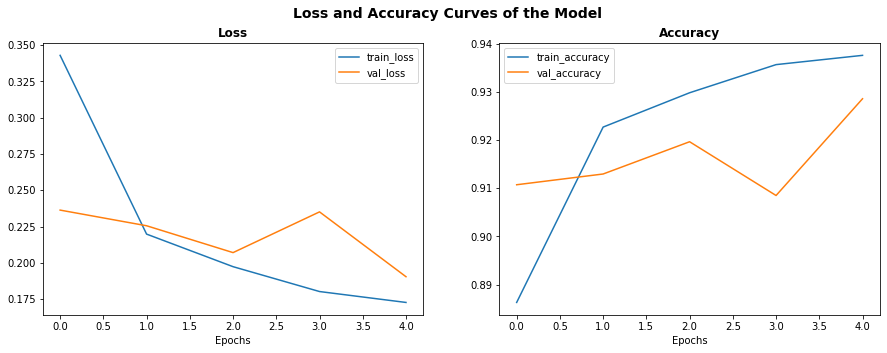

In [ ]:
plot_loss_curves(history_efficientb0_2)

Results are really impressive, we are getting ~90% accuracy, which would be very difficult for our simple baseline model.

But, the loss and accuracy curves are indicatting that the model is overfitting.

### 2. ResNet

Now, we will use one more very famous module called ResNet(Residual Networks). This module have 3 architecture namely ResNet50, ResNet101 and ResNet152. 

![](https://miro.medium.com/max/1400/0*9LqUp7XyEx1QNc6A.png)

In [ ]:
# ResNet50 Model
base_resnet50v2_model = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False)
base_resnet50v2_model.trainable = False

# Functional Model
inputs = Input(shape=(150,150,3), dtype = tf.uint8, name='input_layer')
x = tf.cast(inputs, tf.float32)
x = tf.keras.applications.resnet_v2.preprocess_input(x)
x = base_resnet50v2_model(x)
x = GlobalAveragePooling2D(name='global_average_pool2d')(x)
x = Dense(len(label_names), name='dense_output_layer')(x)
outputs = Activation('softmax', dtype=tf.float32, name='softmax_float32')(x) 
model_3 = Model(inputs, outputs)

# Compiling the model
model_3.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
history_resnet50v2_3 = model_3.fit(train_data,
                                   epochs=5,
                                   steps_per_epoch=len(train_data),
                                   validation_data=test_data,
                                   validation_steps=int(0.15 * len(test_data)),
                                   callbacks=[tensorboard_callbacks('tensorboard_callbacks', 'resnet50v2_model_3')])

94668760/94668760 [==============================] - 1s 0us/step
Saving the log of Tensorboard Callabck in directory: tensorboard_callbacks/resnet50v2_model_3/20221026-14:40:31
Epoch 1/5
439/439 [==============================] - 30s 59ms/step - loss: 0.3584 - accuracy: 0.8710 - val_loss: 0.3194 - val_accuracy: 0.8705
Epoch 2/5
439/439 [==============================] - 24s 55ms/step - loss: 0.2376 - accuracy: 0.9136 - val_loss: 0.4103 - val_accuracy: 0.8571
Epoch 3/5
439/439 [==============================] - 24s 55ms/step - loss: 0.2009 - accuracy: 0.9264 - val_loss: 0.3039 - val_accuracy: 0.8795
Epoch 4/5
439/439 [==============================] - 25s 55ms/step - loss: 0.1809 - accuracy: 0.9342 - val_loss: 0.3377 - val_accuracy: 0.8817
Epoch 5/5
439/439 [==============================] - 24s 55ms/step - loss: 0.1655 - accuracy: 0.9401 - val_loss: 0.2707 - val_accuracy: 0.8951


In [ ]:
# Checking our 
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 150, 150, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 150, 150, 3)       0         
                                                                 
 tf.math.truediv_20 (TFOpLam  (None, 150, 150, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract (TFOpLambd  (None, 150, 150, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 global_average_pool2d (Glob  (None, 2048)             0   

In [ ]:
# Evaluating the model on test data
model_3.evaluate(test_data)

94/94 [==============================] - 6s 60ms/step - loss: 0.2678 - accuracy: 0.9063


[0.2678416967391968, 0.906333327293396]

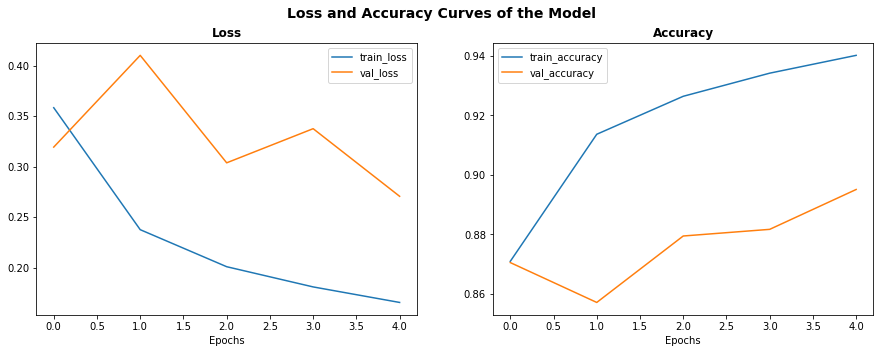

In [ ]:
plot_loss_curves(history_resnet50v2_3)

Both are showing good outputs and performance on the dataset. Still, EfficientNetB0 is better than ResNet50V2.

Now, we will try data augmentation on the EfficientNetB0

In [ ]:
# Creating data augmentation model(similar to the above modification done during the baseline data augmentation)
data_augmentation = Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.2),
  RandomZoom(0.2),
  RandomHeight(0.2),
  RandomWidth(0.2)
], name ="data_augmentation")

In [ ]:
# Creating functional EfficientNetB0 model with data augmentation
initial_epochs = 5

inputs = Input(shape=(150,150,3), name='input_layer')
x = data_augmentation(inputs)
x = base_efficientnetb0_model(x, training=False)
x = GlobalAveragePooling2D(name='global_average_pool2d')(x)
x = Dense(len(label_names), name='dense_output_layer')(x)
outputs = Activation('softmax', dtype=tf.float32, name='softmax_float32')(x) 
model_4 = Model(inputs, outputs)

# Compiling the model
model_4.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
history_efficientb0_4 = model_4.fit(train_data,
                                    epochs=initial_epochs,
                                    steps_per_epoch=len(train_data),
                                    validation_data=test_data,
                                    validation_steps=int(0.15 * len(test_data)),
                                    callbacks=[tensorboard_callbacks('tensorboard_callbacks', 'efficientnetb0_dataaug_model_4'),
                                              model_checkpoint])

Saving the log of Tensorboard Callabck in directory: tensorboard_callbacks/efficientnetb0_dataaug_model_4/20221026-14:43:33
Epoch 1/5
439/439 [==============================] - ETA: 0s - loss: 0.4985 - accuracy: 0.8266
Epoch 1: val_accuracy improved from -inf to 0.90625, saving model to model_checkpoint/checkpoint.ckpt
439/439 [==============================] - 74s 152ms/step - loss: 0.4985 - accuracy: 0.8266 - val_loss: 0.2501 - val_accuracy: 0.9062
Epoch 2/5
439/439 [==============================] - ETA: 0s - loss: 0.3365 - accuracy: 0.8766
Epoch 2: val_accuracy improved from 0.90625 to 0.91295, saving model to model_checkpoint/checkpoint.ckpt
439/439 [==============================] - 47s 107ms/step - loss: 0.3365 - accuracy: 0.8766 - val_loss: 0.2365 - val_accuracy: 0.9129
Epoch 3/5
439/439 [==============================] - ETA: 0s - loss: 0.3116 - accuracy: 0.8837
Epoch 3: val_accuracy improved from 0.91295 to 0.91964, saving model to model_checkpoint/checkpoint.ckpt
439/439 [==

94/94 [==============================] - 3s 34ms/step - loss: 0.2727 - accuracy: 0.9053


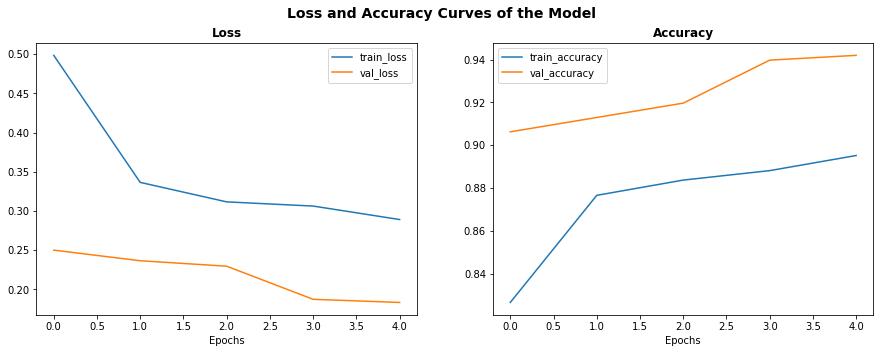

In [ ]:
# Evaluating the model on test data
model_4.evaluate(test_data)

# Plotting loss curves
plot_loss_curves(history_efficientb0_4)

Looks like that the data augmentation is genralizing the data well and there might be a possibility that the curves will get better with longer epochs.

---

## 8. Fine-Tunning - Transfer Learning



![](https://storage.googleapis.com/lds-media/images/transfer-learning-fine-tuning-approach.width-1200.jpg)

Till now, we were working on a pretrained EfficientNetB0 Model with a feature extraction method in which all the layers were frozen during training.

For our next experiment we will be training the same model with a fine-tunning method where we will be unfreezing some of the top layers of the EfficientNetB0 and running the model for some more epochs.

In [ ]:
# how may layers do we have in our last model?
model_4.layers

In [ ]:
# so our efficientnetb0 layer is the 2nd layer, lets check which are trainable
for layer in model_4.layers:
    print(layer.trainable)

True
True
False
True
True
True


This confirms that all the layers are frozen in the EfficientNetB0.

In [ ]:
# unfreezing all the layers of EfficientNetB0
base_efficientnetb0_model.trainable = True

# freezing all layers except for last 100
for layers in base_efficientnetb0_model.layers[:-100]:
    layers.trainable = False

In [ ]:
# checking the trainable layers in our core model
for i, layers in enumerate(base_efficientnetb0_model.layers):
    print(i, layers.name, layers.trainable)

0 input_21 False
1 rescaling_19 False
2 normalization_19 False
3 tf.math.truediv_19 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_sq

In [ ]:
# Total trainable variables in our model -> 
# there should be 2 from output layers - the weghts and bias, and remaing layers are from EfficientNetb0
len(model_4.trainable_variables)

90

Good, now we have fine-tunned our EfficientNetB0 model, we have unfreezed top 10 layers. These layers will be trained, when our model will be running.

Before, fitting our model, lets create some callbacks which will help in improving our models:
1. **EarlyStopping Callback** - This will help in tracking our training metrics on every intervals and stop the model automaticallly when its not imporoving at a certain number of epochs.
2. **ReduceLROnPlateau** - This will help in deciding the improvement needed in the learning rate of our optimization metrics. It monitors the learning rate and reduces when the model is not improving.

In [ ]:
# Creating EarlyStopping callback - it will monitor validation loss for 3 epochs.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3)

# Creating Learning Rate Reduction callback - it will monitor validation loss for 2 epochs and reduce at a factor of 0.2.
reduce_lr_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                         factor=0.2,
                                                         patience=2,
                                                         verbose=1,
                                                         min_lr=1e-7)

# Compiling the model after all adjustment
model_4.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(1e-4),
                metrics=['accuracy'])

All the pre-processing is done for fine-tunning the model, lets fit the model.

In [ ]:
# fine tunning for another 20 epochs, we are using EarlyStopping which will end it much early and not train it for 20 epochs.
fine_tune_epochs = initial_epochs + 15

# Fitting our model this time with fine-tunned EfficientNetB0
history_efficientb0_5 = model_4.fit(train_data,
                                    epochs=fine_tune_epochs,
                                    steps_per_epoch=len(train_data),
                                    initial_epoch=history_efficientb0_4.epoch[-1],
                                    validation_data=test_data,
                                    validation_steps=int(0.15 * len(test_data)),
                                    callbacks=[tensorboard_callbacks('tensorboard_callbacks', 'efficientnetb0_finetunnned_model_4'),
                                               early_stopping,
                                               reduce_lr_plateau])

Saving the log of Tensorboard Callabck in directory: tensorboard_callbacks/efficientnetb0_finetunnned_model_4/20221026-14:47:49
Epoch 5/20
439/439 [==============================] - 54s 105ms/step - loss: 0.2778 - accuracy: 0.8997 - val_loss: 0.1338 - val_accuracy: 0.9509 - lr: 1.0000e-04
Epoch 6/20
439/439 [==============================] - 41s 93ms/step - loss: 0.2113 - accuracy: 0.9237 - val_loss: 0.2393 - val_accuracy: 0.9040 - lr: 1.0000e-04
Epoch 7/20
439/439 [==============================] - 40s 91ms/step - loss: 0.1743 - accuracy: 0.9349 - val_loss: 0.1297 - val_accuracy: 0.9509 - lr: 1.0000e-04
Epoch 8/20
439/439 [==============================] - 40s 91ms/step - loss: 0.1536 - accuracy: 0.9406 - val_loss: 0.3141 - val_accuracy: 0.8929 - lr: 1.0000e-04
Epoch 9/20
439/439 [==============================] - ETA: 0s - loss: 0.1344 - accuracy: 0.9495
Epoch 9: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
439/439 [==============================] - 41s 93ms/st

In [ ]:
# Evaluate test data
model_loss, model_accuracy = model_4.evaluate(test_data)
model_loss, model_accuracy

94/94 [==============================] - 3s 33ms/step - loss: 0.2327 - accuracy: 0.9270


(0.23266349732875824, 0.9269999861717224)

In [ ]:
# Loss and accuracy curves need to be compared
# Creating a function for loss and accuracy curve comparison

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

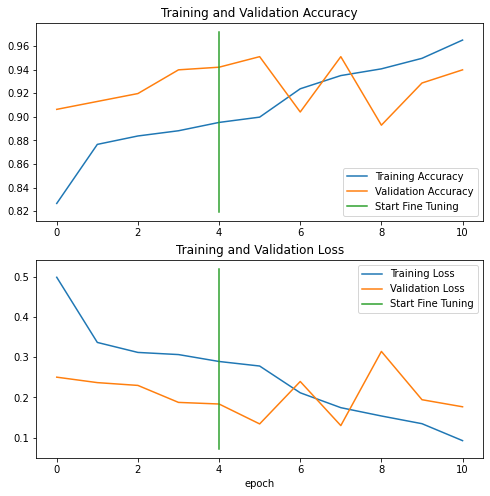

In [ ]:
compare_historys(original_history=history_efficientb0_4, 
                 new_history=history_efficientb0_5, 
                 initial_epochs=5)

The result we are getting is good, accuracy is above ~90%. This is the best performance we are getting from EfficientNetB0 Fine-tunned model with Data Augmentaation. There won't be much difference between the feature extraction method and fine-tunning method that is due to the fact that the EfficientNetB0 is a model that is been trained on ImageNet dataset which has multiple different categories of images.

The reason we are only fine-tunning on a limited layers is because we have a very limited dataset, EfficientNetB0 are models that are used on a dataset with 1000 classes, this the reason we have only trained the top 100 layers. To get the best out of this model we need a huge dataset, but for now we have got a good result out of this model.

---

## 9. Model Comparision using Tensorboard

We have been saving our model performance using the tensorboard callback, lets use it and visualize it on the tensorboard website.

In [ ]:
#!tensorboard dev upload --logdir ./training_logs \
#--name "All the models of the Intel Scene Classification Project" \
#--description "Training result of all the model, starting with a baseline model, and moving forward with data augmentation, next performing feature extraction on EfficientNetB0 and ResNetV2 with data augmentation with the best one and fine tunning in the final model." \
#--one_shot

## 10. Evaluating the Performance of the Model

We have seen our models performance and understood that it's performing better than the initial baseline and giving us a validation accuracy of ~90%.

Lets deep diver into the metrics of the model and some more visualization.

### Predictions with the Trained Model

To make a evaluation, we need to make some prediction on our test data which will help us in comparing the prediction with actual results. 

In [ ]:
# Make prediction with the model_4
pred_probs = model_4.predict(test_data, verbose=1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
94/94 [==============================] - 5s 31ms/step


The prediction of our test data will be in the form of prediction probability tensor for our 6 classes. Where the maximum value will be the class that is been predicted by the model.

In [ ]:
# How many predictions do we have? and whats the shape of the prediction? 
# How does it looks(first 5)? and whats the predicted class?
print(f'Total number of test data predicted: {len(pred_probs)}\n')
print(f'Total number of test data predicted: {pred_probs.shape}\n')
print(f'First 5 predicted tensor:\n{pred_probs[:5]}\n')
print(f'Predicted class of the first tensor:\n{label_names[pred_probs[0].argmax()]}')

Total number of test data predicted: 3000

Total number of test data predicted: (3000, 6)

First 5 predicted tensor:
[[9.9998856e-01 6.4879785e-08 1.6051188e-06 1.7232460e-07 6.8032873e-06
  2.7383055e-06]
 [9.9991143e-01 2.1271530e-08 8.1222151e-07 1.1332051e-07 9.0656965e-07
  8.6756896e-05]
 [9.7581351e-01 7.0500387e-06 5.1967891e-05 1.5364229e-05 1.0234134e-04
  2.4009680e-02]
 [9.9702746e-01 6.2911204e-06 6.0789712e-06 3.5818487e-06 1.1775300e-04
  2.8389315e-03]
 [9.9807775e-01 1.1163227e-06 1.0686044e-05 1.8145463e-05 1.8657361e-03
  2.6691547e-05]]

Predicted class of the first tensor:
buildings


In [ ]:
# Get the class prediction of each image
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Now, that we have got the predicted probabilities and the classes.

We will need the actual data for comparision, which we can get it from our batch dataset.

In [ ]:
y_labels = []
for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax())
y_labels[:20]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

### Evaluate the Models Prediction

We have both the predictions and the actual labels of our test dataset. 

To calculate the accuracy, we can use the scikit learn package to perform a simple accuracy score.

After this we will visualize the result using the confusion matrix. 

In [ ]:
# Getting the accuracy score by comparing the predicted and actual labels.
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy, model_accuracy # result will be similar to each other - some minor difference due to precision.

(0.927, 0.9269999861717224)

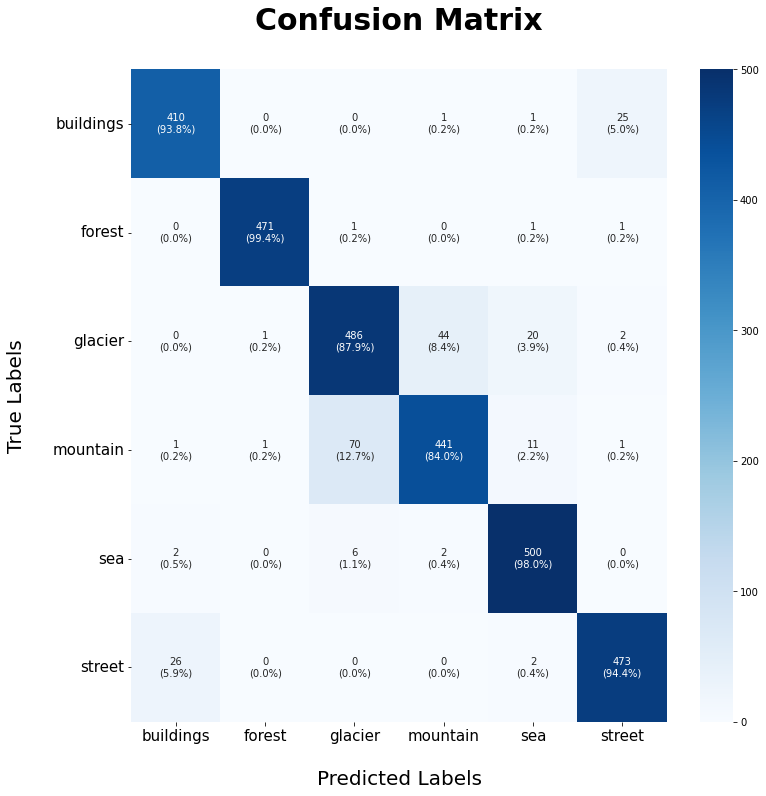

In [ ]:
# Now visualizing the comparison using confusion matrix.

# Create confusion matrix using scikit-learn
cm = confusion_matrix(y_true=y_labels, y_pred=pred_classes)

# Visualizing using the seaborn heatmap to create CF_Matrix
count = ["{0:0.0f}".format(value) for value in cm.flatten()]
percent = ["{0:.1%}".format(value) for value in ((cm.astype('float') / cm.sum(axis = 1))).flatten()]
labels = [f'{count}\n({percent})' for count, percent in zip(count, percent)]
labels = np.asarray(labels).reshape(6, 6)

# sns heatmap with confusion matrix
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(cm, annot=labels, fmt="", cmap="Blues")

# Setting annotation
ax.set_title("Confusion Matrix\n", fontsize=30, weight='bold')
ax.set_xlabel("\nPredicted Labels", fontsize=20)
ax.set_xticklabels(label_names, fontsize=15)
ax.set_ylabel("True Labels\n", fontsize=20)
ax.set_yticklabels(label_names, rotation=0, fontsize=15);

Looking at the visualization, This is what we can understand - 
1. The confusion matrix is moving from Top-Left to Bottom-Right, diagonally, which is what we need in our confusion matrix. This shows us that we have a perfect confusion matrix representation. 
2. Our model is getting confused on mountain and glacier images and on buildings and street images. This might be because they look visually quite similar. for example, there might be snow mountains and huge glacier or sea and glacier might have same features that looks quite similar, even street and buildings images to have some amount of features in each other.

We can go much deeper with the evaluation using scikit-learn classification_report function.

In [ ]:
# Creating classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.9339407744874715,
  'recall': 0.9382151029748284,
  'f1-score': 0.9360730593607305,
  'support': 437},
 '1': {'precision': 0.9957716701902748,
  'recall': 0.9936708860759493,
  'f1-score': 0.9947201689545934,
  'support': 474},
 '2': {'precision': 0.8632326820603907,
  'recall': 0.8788426763110307,
  'f1-score': 0.8709677419354839,
  'support': 553},
 '3': {'precision': 0.9036885245901639,
  'recall': 0.84,
  'f1-score': 0.8706811451135241,
  'support': 525},
 '4': {'precision': 0.9345794392523364,
  'recall': 0.9803921568627451,
  'f1-score': 0.9569377990430622,
  'support': 510},
 '5': {'precision': 0.9422310756972112,
  'recall': 0.9441117764471058,
  'f1-score': 0.9431704885343969,
  'support': 501},
 'accuracy': 0.927,
 'macro avg': {'precision': 0.9289073610463081,
  'recall': 0.9292054331119433,
  'f1-score': 0.9287584004902986,
  'support': 3000},
 'weighted avg': {'precision': 0.926875107217814,
  'recall': 0.927,
  'f1-score': 0.926626913922578,
  'suppo

In [ ]:
# Creating a dictionary with f1-score
class_f1_scores = {}
for k,v in classification_report_dict.items():
    if k=="accuracy":
        break
    else:
        class_f1_scores[label_names[int(k)]] = v["f1-score"]
class_f1_scores

{'buildings': 0.9360730593607305,
 'forest': 0.9947201689545934,
 'glacier': 0.8709677419354839,
 'mountain': 0.8706811451135241,
 'sea': 0.9569377990430622,
 'street': 0.9431704885343969}

Now, that we have the f1-score values, lets format it in pandas dataframe and visualize the data.

In [ ]:
# Turn f1-scores into dataframe for visualization
f1_scores_df = pd.DataFrame({'class_name': list(class_f1_scores.keys()),
                             'f1-score': list(class_f1_scores.values())}).sort_values('f1-score', ascending=False)
f1_scores_df

,class_name,f1-score
1,forest,0.994720
4,sea,0.956938
5,street,0.943170
0,buildings,0.936073
2,glacier,0.870968
3,mountain,0.870681


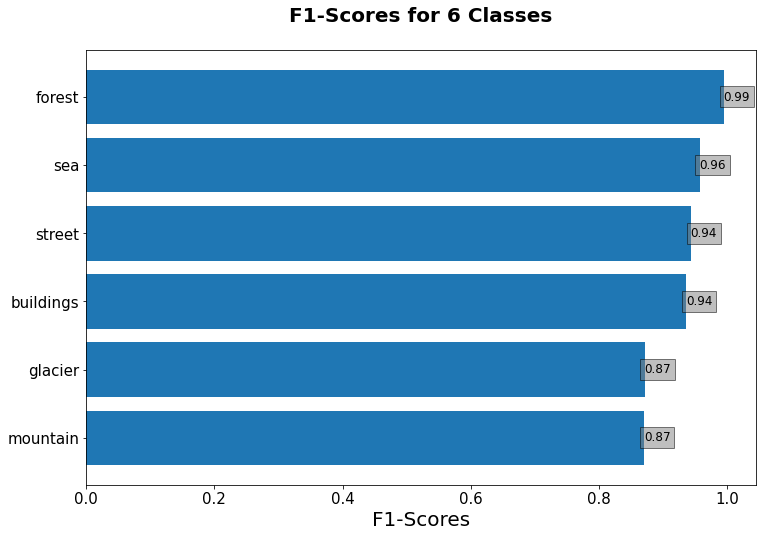

In [ ]:
# Visualizing the dataframe in a horizontal bar chart.
fig,ax = plt.subplots(figsize=(12,8))
barh_plot = ax.barh(range(len(f1_scores_df)), f1_scores_df['f1-score'].values)
ax.set_yticks(range(len(f1_scores_df)))
ax.set_yticklabels(f1_scores_df['class_name'].values, fontsize=15)
ax.set_xlabel('F1-Scores', fontsize=20)
ax.set_title("F1-Scores for 6 Classes\n", fontsize=20, weight='bold')
plt.xticks(fontsize=15)
ax.invert_yaxis()
for i in barh_plot:
    width = i.get_width()
    ax.text(width + 0.02, i.get_y() + 0.45, f"{width:.2f}", ha='center', bbox=dict(facecolor='grey', alpha=0.5), fontsize=12);

Looking at the bar plot, we can see that information we received from confusion matrix is similar over here also. Mountain and glacier images are performing worst(below 90%) while forest is performing the best(99%).

### Finding the Wrong Predictions

Now, that we have understood which category is performing at what level, lets visualize and see the one's that are predicted wrong and understand where we need to make some changes that will help in improving our models performance.

In [ ]:
# First, lets get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files(f"{test_dir}*/*.jpg", shuffle=False):
    filepaths.append(filepath.numpy())
filepaths[:10]

[b'data/seg_test/seg_test/buildings/20057.jpg',
 b'data/seg_test/seg_test/buildings/20060.jpg',
 b'data/seg_test/seg_test/buildings/20061.jpg',
 b'data/seg_test/seg_test/buildings/20064.jpg',
 b'data/seg_test/seg_test/buildings/20073.jpg',
 b'data/seg_test/seg_test/buildings/20074.jpg',
 b'data/seg_test/seg_test/buildings/20078.jpg',
 b'data/seg_test/seg_test/buildings/20083.jpg',
 b'data/seg_test/seg_test/buildings/20094.jpg',
 b'data/seg_test/seg_test/buildings/20096.jpg']

We have all the data that we need for our futher analysis on the wrong prediction data. We can start by creating a dataframe and move forward with a proper visualization.

Data required for our evaluation analysis -
1. img_path - Filepath of the images.
2. y_true - True or Actual labels of the images.
3. y_pred - Predicted labels of the images
4. pred_prob - Max predicted probability for the images.
5. y_true_classname - True class name of the images.
6. y_pred_classname - Predicted class name of the images.
7. pred_correct - True for correct prediction and False for wrong prediction.

In [ ]:
# Creating a dataframe with all of the true and predicted data
pred_analysis_df = pd.DataFrame({"img_path": filepaths,
                                 "y_true": y_labels,
                                 "y_pred": pred_classes,
                                 "pred_prob": pred_probs.max(axis=1), 
                                 "y_true_classname": [label_names[i] for i in y_labels],
                                 "y_pred_classname": [label_names[i] for i in pred_classes]}) 
pred_analysis_df.head()

,img_path,y_true,y_pred,pred_prob,y_true_classname,y_pred_classname
0,b'data/seg_test/seg_test/buildings/20057.jpg',0,0,0.999989,buildings,buildings
1,b'data/seg_test/seg_test/buildings/20060.jpg',0,0,0.999911,buildings,buildings
2,b'data/seg_test/seg_test/buildings/20061.jpg',0,0,0.975814,buildings,buildings
3,b'data/seg_test/seg_test/buildings/20064.jpg',0,0,0.997027,buildings,buildings
4,b'data/seg_test/seg_test/buildings/20073.jpg',0,0,0.998078,buildings,buildings


In [ ]:
# Whether the prediction is correct or not?
pred_analysis_df["pred_correct"] = pred_analysis_df["y_true"] == pred_analysis_df["y_pred"]
pred_analysis_df.head()

,img_path,y_true,y_pred,pred_prob,y_true_classname,y_pred_classname,pred_correct
0,b'data/seg_test/seg_test/buildings/20057.jpg',0,0,0.999989,buildings,buildings,True
1,b'data/seg_test/seg_test/buildings/20060.jpg',0,0,0.999911,buildings,buildings,True
2,b'data/seg_test/seg_test/buildings/20061.jpg',0,0,0.975814,buildings,buildings,True
3,b'data/seg_test/seg_test/buildings/20064.jpg',0,0,0.997027,buildings,buildings,True
4,b'data/seg_test/seg_test/buildings/20073.jpg',0,0,0.998078,buildings,buildings,True


The dataframe is complete and ready for futher analysis, to understand which images are predicted wrong by our model.

In [ ]:
# Getting the top 100 wrong predictions
top_100_wrong = pred_analysis_df[pred_analysis_df["pred_correct"] == False].sort_values("pred_prob", ascending=False)[:100].reset_index()
top_100_wrong

,index,img_path,y_true,y_pred,pred_prob,y_true_classname,y_pred_classname,pred_correct
0,2701,b'data/seg_test/seg_test/street/21694.jpg',5,0,0.999781,street,buildings,False
1,1726,b'data/seg_test/seg_test/mountain/22176.jpg',3,4,0.999721,mountain,sea,False
2,1490,b'data/seg_test/seg_test/mountain/20304.jpg',3,4,0.999647,mountain,sea,False
3,1735,b'data/seg_test/seg_test/mountain/22207.jpg',3,4,0.999602,mountain,sea,False
4,88,b'data/seg_test/seg_test/buildings/20846.jpg',0,5,0.999183,buildings,street,False
...,...,...,...,...,...,...,...,...
95,1134,b'data/seg_test/seg_test/glacier/21816.jpg',2,4,0.853139,glacier,sea,False
96,1910,b'data/seg_test/seg_test/mountain/23578.jpg',3,2,0.851574,mountain,glacier,False
97,1535,b'data/seg_test/seg_test/mountain/20662.jpg',3,2,0.850250,mountain,glacier,False
98,1433,b'data/seg_test/seg_test/glacier/24126.jpg',2,4,0.847809,glacier,sea,False


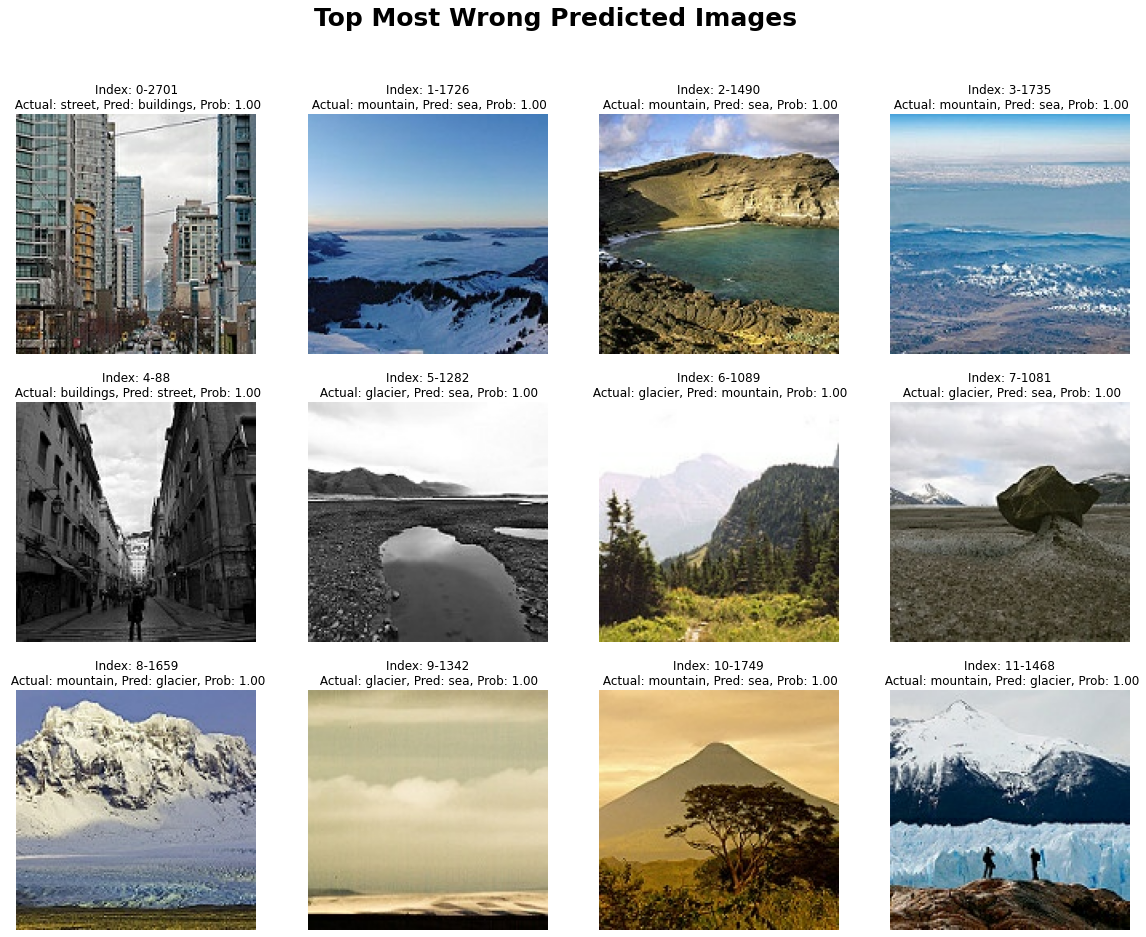

In [ ]:
# Visualize the wrong prediction images
first_img = 0 # change this to view different images
total_img = 12
plt.figure(figsize=(20, 15))
for i, row in enumerate(top_100_wrong[first_img:first_img+total_img].itertuples()): 
    plt.subplot(3, 4, i+1)
    img = tf.io.read_file(row[2])
    img = tf.io.decode_image(img)
    img = tf.image.resize(img, [150,150])
    plt.imshow(img/255.)
    plt.title(f"Index: {row[0]}-{row[1]}\n Actual: {row[6]}, Pred: {row[7]}, Prob: {row[5]:.2f}")
    plt.suptitle("Top Most Wrong Predicted Images", fontsize=25, weight='bold')
    plt.axis(False)

## Conclusion:

After going through multiple images, we can reach to a conclusion that - 

1. **Incorrect Label Names** - Many of the images are wrongly labelled. This means that the images were not present in the correct directory. For example, images of mountain and glacier, and street and building need more attention. 
2. **Images with addition disturbance** - There are images that are complicated for the model to understand, most of them are edited images. For example, a image with glacier collage is been predicted by the model as a sea image, this might be due to the fact that the whole images looks completly blue.
3. **Wrong Images** - Our Model is been trained on only 6 categories, images out of this categories are present with wrong labels. For example, a image of a barren land is present in the glacier directory, this image should not be a part of the dataset.

Visualizing it from every angle, we can see that the model is performing really good and the prediction is also better even though there are errors in our dataset. We can also improve the model by training it for more images of natural scenery and unfreezing all the layers in the fine-tunned EfficientNetB0 Model.

---